In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node


No vtk
File does not exist: /shared/CSHL_data_processed/MD635/MD635_anchor.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_sorted_filenames.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD653/MD653_anchor.txt
File does not exist: /shared/CSHL_data_processed/MD653/MD653_sorted_filenames.txt
File does not exist: /shared/CSHL_data_processed/MD653/MD653_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD653/MD653_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD652/MD652_anchor.txt
File does not exist: /shared/CSHL_data_processed/MD652/MD652_sorted_filenames.txt
File does not exist: /shared/CSHL_data_processed/MD652/MD652_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD652/MD652_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD642/MD642_anchor.txt
File does not exist: 

In [3]:
stack_fixed = 'MD591'
stack_moving = 'atlasV3'

In [12]:
classifier_setting = 30
warp_setting = 1

Setting environment for AWS compute node


In [5]:
from pandas import read_hdf, DataFrame, read_csv
registration_settings = read_csv(REGISTRATION_SETTINGS_CSV, header=0, index_col=0)

In [6]:
registration_settings

,upstream_warp_id,transform_type,terminate_thresh,grad_computation_sample_number,grid_search_sample_number,std_tx,std_ty,std_tz,std_theta_xy,surround_weight,regularization_weight
warp_id,,,,,,,,,,,
1,None,affine,0.000010,100000.0,1000.0,100,100,100,30,0.0,NaN
2,1,rigid,0.000010,100000.0,10000.0,10,100,100,100,30.0,0.000000
4,1,rigid,0.000001,100000.0,10000.0,100,100,100,10,0.0,0.000001
5,1,rigid,0.000001,100000.0,10000.0,100,100,100,30,0.0,0.000000
6,1,affine,0.000010,100000.0,10000.0,100,100,100,30,-0.5,0.000000
7,None,rigid,0.000001,100000.0,1000.0,50,50,50,10,0.0,NaN
10,None,rigid,0.000010,100000.0,1000.0,100,100,100,30,0.0,NaN
11,1,affine,0.000010,100000.0,10000.0,100,100,100,30,-0.1,0.000000


In [7]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = warp_properties['grad_computation_sample_number']
grid_search_sample_number = warp_properties['grid_search_sample_number']
std_tx = warp_properties['std_tx']
std_ty = warp_properties['std_ty']
std_tz = warp_properties['std_tz']
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy'])

upstream_warp_id                    None
transform_type                     rigid
terminate_thresh                   1e-05
grad_computation_sample_number    100000
grid_search_sample_number           1000
std_tx                               100
std_ty                               100
std_tz                               100
std_theta_xy                          30
surround_weight                        0
regularization_weight                NaN
Name: 10, dtype: object


In [8]:
# if warp_setting == 1:
#     upstream_warp_setting = None
#     transform_type = 'affine'
    
#     terminate_thresh = 1e-5
#     grad_computation_sample_number = 1e5
#     grid_search_sample_number = 1000
#     std_tx = 100
#     std_ty = 100
#     std_tz = 100
#     std_theta_xy = np.deg2rad(30)

# elif warp_setting == 7:
#     upstream_warp_setting = None
#     transform_type = 'rigid'
    
#     terminate_thresh = 1e-6
#     grad_computation_sample_number = 1e5
#     grid_search_sample_number = 1000
#     std_tx = 50
#     std_ty = 50
#     std_tz = 50
#     std_theta_xy = np.deg2rad(10)
    
# elif warp_setting == 10:
#     upstream_warp_setting = None
#     transform_type = 'rigid'
    
#     terminate_thresh = 1e-5
#     grad_computation_sample_number = 1e5
#     grid_search_sample_number = 1000
#     std_tx = 100
#     std_ty = 100
#     std_tz = 100
#     std_theta_xy = np.deg2rad(30) # important 10 degrees is not enough

# else:
#     raise Exception('Warp setting not recognized.')

In [9]:
volume_moving, structure_to_label_moving, label_to_structure_moving = \
DataManager.load_score_volume_all_known_structures(stack=stack_moving, sided=True)

print volume_moving[1].shape

File does not exist: /shared/CSHL_volumes/atlasV3/atlasV3_down32_annotationVolume/atlasV3_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Score volume for 10N_L does not exist.
Score volume for 10N_R does not exist.
Score volume for 12N does not exist.
Score volume for 3N_L does not exist.
Score volume for 3N_R does not exist.
Score volume for 4N_L does not exist.
Score volume for 4N_R does not exist.
Score volume for 5N_L does not exist.
Score volume for 5N_R does not exist.
Score volume for 6N_L does not exist.
Score volume for 6N_R does not exist.
Score volume for 7N_L does not exist.
Score volume for 7N_R does not exist.
Score volume for 7n_L does not exist.
Score volume for 7n_R does not exist.
Score volume for AP does not exist.
Score volume for Amb_L does not exist.
Score volume for Amb_R does not exist.
Score volume for DC_L does not exist.
Score volume for DC_R does not exist.
Score volume for IC does not exist.
Score volume f

IndexError: list index out of range

In [77]:
volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
DataManager.load_score_volume_all_known_structures(stack=stack_fixed, classifier_setting=classifier_setting, 
                                                   sided=False)

print volume_fixed[1].shape

File does not exist: /shared/CSHL_data_processed/MD635/MD635_anchor.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_sorted_filenames.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD653/MD653_anchor.txt
File does not exist: /shared/CSHL_data_processed/MD653/MD653_sorted_filenames.txt
File does not exist: /shared/CSHL_data_processed/MD653/MD653_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD653/MD653_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD652/MD652_anchor.txt
File does not exist: /shared/CSHL_data_processed/MD652/MD652_sorted_filenames.txt
File does not exist: /shared/CSHL_data_processed/MD652/MD652_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD652/MD652_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD642/MD642_anchor.txt
File does not exist: /shared

IndexError: list index out of range

In [57]:
label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
                     for label_m, name_m in label_to_structure_moving.iteritems()
                     if name_m in ['7N_L', '7N_R', '12N', '5N_L', 'Pn_R', 'SNR_L', 
                                   'VLL_R', '7n_L', 'Tz_R', 'VCA_L', 'VCP_R']}

# label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
#                      for label_m, name_m in label_to_structure_moving.iteritems()}

In [58]:
# volume_moving_structure_sizes = {l: np.count_nonzero(vol > 0) for l, vol in volume_moving.iteritems()}

In [59]:
# structures_sorted_by_size = [x[1] for x in sorted((s, label_to_structure_moving[l]) for l, s in volume_moving_structure_sizes.iteritems())]
# print structures_sorted_by_size

In [60]:
label_weights_m = {}
for label_m, name_m in label_to_structure_moving.iteritems():
    if 'surround' in name_m:
        label_weights_m[label_m] = 0
    else:
        label_weights_m[label_m] = 1
#         label_weights_m[label_m] = np.minimum(1e5 / volume_moving_structure_sizes[label_m], 1.)

# Compute Registration

In [61]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


In [62]:
# aligner.set_centroid(centroid_m='origin', centroid_f='origin')
aligner.set_centroid(centroid_m='volume_centroid', centroid_f='centroid_m')
# aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', indices_m=[structure_to_label_moving['7N_L']])

m: [ 215.   186.5  184.5] f: [ 215.   186.5  184.5]


In [63]:
gradient_filepath_map_f = \
{ind_f: DataManager.get_volume_gradient_filepath_template(\
                                                          stack=stack_fixed, structure=label_to_structure_fixed[ind_f],
                                                          classifier_setting=classifier_setting)
 for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [64]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s-170 = 2 mins

set([2, 5, 7, 8, 16, 21, 25, 26, 27, 28])


load gradient 2: 9.461863 seconds
load gradient 5: 8.372131 seconds
load gradient 7: 9.781141 seconds
load gradient 8: 7.881008 seconds
load gradient 16: 7.521163 seconds
load gradient 21: 11.013887 seconds
load gradient 25: 10.349489 seconds
load gradient 26: 12.370823 seconds
load gradient 27: 9.623147 seconds
load gradient 28: 9.816252 seconds
overall: 96.191863 seconds


In [65]:
aligner.set_label_weights(label_weights=label_weights_m)

In [66]:
# For rigid, 
# grad_computation_sample_number = 1e5 is desired
# grid_search_iteration_number and grid_search_sample_number seem to be unimportant as well, set to 100
# lr1=10, lr2=.1 is best

# For affine, 
# lr2 = .001 is too slow; 0.1 rises faster than 0.01
# lr1 does not matter
# plateus around iteration 100, but keep rising afterwards.
# grad_computation_sample_number does not make a difference

# while True:

T_all_trials = []
scores_all_trials = []

for _ in range(5):

    try:
        T, scores = aligner.optimize(type=transform_type, max_iter_num=1000, history_len=10, 
                                     terminate_thresh=terminate_thresh,
                                     grid_search_iteration_number=30,
                                     grid_search_sample_number=grid_search_sample_number,
                                     grad_computation_sample_number=grad_computation_sample_number,
                                     lr1=10, lr2=0.1,
                                     std_tx=std_tx, std_ty=std_ty, std_tz=std_tz, std_theta_xy=std_theta_xy)
                
        T_all_trials.append(T)
        scores_all_trials.append(scores)
        
    except Exception as e:
        sys.stderr.write('%s\n' % e)


grid search: 6.062462 seconds
tx_best: 3.03 (voxel), ty_best: -22.86, tz_best: -47.72, theta_xy_best: 371.17 (deg)
sigma_tx: 100.00 (voxel), sigma_ty: 100.00, sigma_tz: 100.00, sigma_theta_xy: 1718.87 (deg)
-inf 0.208812
grid search: 4.057170 seconds
tx_best: 45.58 (voxel), ty_best: 21.70, tz_best: 13.07, theta_xy_best: -5.60 (deg)
sigma_tx: 71.65 (voxel), sigma_ty: 71.65, sigma_tz: 71.65, sigma_theta_xy: 1231.63 (deg)
0.208812 0.224696
grid search: 3.155139 seconds
tx_best: 47.40 (voxel), ty_best: 52.08, tz_best: -8.87, theta_xy_best: 1.83 (deg)
sigma_tx: 51.34 (voxel), sigma_ty: 51.34, sigma_tz: 51.34, sigma_theta_xy: 882.50 (deg)
0.224696 0.265277
grid search: 2.452401 seconds
tx_best: 47.40 (voxel), ty_best: 52.08, tz_best: -8.87, theta_xy_best: 1.83 (deg)
sigma_tx: 36.79 (voxel), sigma_ty: 36.79, sigma_tz: 36.79, sigma_theta_xy: 632.34 (deg)
grid search: 1.953632 seconds
tx_best: 47.40 (voxel), ty_best: 52.08, tz_best: -8.87, theta_xy_best: 1.83 (deg)
sigma_tx: 26.36 (voxel), sigm

params_best_upToNow [ 49.36374355  42.81354339  -3.80559846   0.06269718]


step: 0.29 seconds
score: 0.282538
iteration 1
step: 0.29 seconds
score: 0.197009
iteration 2
step: 0.28 seconds
score: 0.265097
iteration 3
step: 0.29 seconds
score: 0.307897
iteration 4
step: 0.28 seconds
score: 0.310716
iteration 5
step: 0.28 seconds
score: 0.323128
iteration 6
step: 0.28 seconds
score: 0.323491
iteration 7
step: 0.28 seconds
score: 0.306632
iteration 8
step: 0.28 seconds
score: 0.363959
iteration 9
step: 0.28 seconds
score: 0.373015
iteration 10
step: 0.28 seconds
score: 0.380661
iteration 11
step: 0.28 seconds
score: 0.387297
iteration 12
step: 0.28 seconds
score: 0.388690
iteration 13
step: 0.28 seconds
score: 0.388250
iteration 14
step: 0.28 seconds
score: 0.382984
iteration 15
step: 0.28 seconds
score: 0.376746
iteration 16
step: 0.28 seconds
score: 0.378041
iteration 17
step: 0.28 seconds
score: 0.378861
iteration 18
step: 0.28 seconds
score: 0.383488
iteration 19
step: 0.28 seconds
score: 0.387194
iteration 20
step: 0.28 seconds
score: 0.388916
iteration 21
s

params_best_upToNow [ 39.75605228  30.71015992   4.96764261  12.4248805 ]


step: 0.29 seconds
score: 0.270891
iteration 1
step: 0.28 seconds
score: 0.249391
iteration 2
step: 0.28 seconds
score: 0.227657
iteration 3
step: 0.28 seconds
score: 0.289454
iteration 4
step: 0.28 seconds
score: 0.327063
iteration 5
step: 0.28 seconds
score: 0.360608
iteration 6
step: 0.28 seconds
score: 0.348115
iteration 7
step: 0.28 seconds
score: 0.312205
iteration 8
step: 0.28 seconds
score: 0.385310
iteration 9
step: 0.28 seconds
score: 0.379884
iteration 10
step: 0.28 seconds
score: 0.361235
iteration 11
step: 0.28 seconds
score: 0.335808
iteration 12
step: 0.28 seconds
score: 0.343133
iteration 13
step: 0.28 seconds
score: 0.381268
iteration 14
step: 0.28 seconds
score: 0.373002
iteration 15
step: 0.28 seconds
score: 0.390087
iteration 16
step: 0.28 seconds
score: 0.383678
iteration 17
step: 0.28 seconds
score: 0.390726
iteration 18
step: 0.28 seconds
score: 0.385717
iteration 19
step: 0.28 seconds
score: 0.389826
iteration 20
step: 0.28 seconds
score: 0.386355
iteration 21
s

params_best_upToNow [-17.33851731 -39.10309246 -10.49506958  12.57987595]


step: 0.27 seconds
score: 0.234448
iteration 1
step: 0.27 seconds
score: 0.245544
iteration 2
step: 0.27 seconds
score: 0.237031
iteration 3
step: 0.26 seconds
score: 0.230767
iteration 4
step: 0.26 seconds
score: 0.236147
iteration 5
step: 0.27 seconds
score: 0.246811
iteration 6
step: 0.27 seconds
score: 0.246030
iteration 7
step: 0.27 seconds
score: 0.246723
iteration 8
step: 0.27 seconds
score: 0.246861
iteration 9
step: 0.27 seconds
score: 0.247179
iteration 10
step: 0.26 seconds
score: 0.245695
iteration 11
step: 0.27 seconds
score: 0.246325
iteration 12
step: 0.27 seconds
score: 0.246890
iteration 13
step: 0.27 seconds
score: 0.247449
iteration 14
step: 0.27 seconds
score: 0.247685
iteration 15
step: 0.27 seconds
score: 0.247551
iteration 16
step: 0.26 seconds
score: 0.247214
iteration 17
step: 0.27 seconds
score: 0.247777
iteration 18
step: 0.26 seconds
score: 0.247887
iteration 19
step: 0.26 seconds
score: 0.247960
iteration 20
step: 0.26 seconds
score: 0.247843
iteration 21
s

params_best_upToNow [ 50.33673129  47.56423502   9.02346536 -31.4155439 ]


step: 0.29 seconds
score: 0.272152
iteration 1
step: 0.28 seconds
score: 0.186476
iteration 2
step: 0.28 seconds
score: 0.249842
iteration 3
step: 0.28 seconds
score: 0.283069
iteration 4
step: 0.28 seconds
score: 0.265219
iteration 5
step: 0.28 seconds
score: 0.314400
iteration 6
step: 0.28 seconds
score: 0.339465
iteration 7
step: 0.28 seconds
score: 0.296321
iteration 8
step: 0.28 seconds
score: 0.368253
iteration 9
step: 0.28 seconds
score: 0.357136
iteration 10
step: 0.28 seconds
score: 0.366586
iteration 11
step: 0.28 seconds
score: 0.347909
iteration 12
step: 0.28 seconds
score: 0.376953
iteration 13
step: 0.28 seconds
score: 0.354964
iteration 14
step: 0.28 seconds
score: 0.347943
iteration 15
step: 0.28 seconds
score: 0.368659
iteration 16
step: 0.28 seconds
score: 0.370610
iteration 17
step: 0.28 seconds
score: 0.373422
iteration 18
step: 0.28 seconds
score: 0.379595
iteration 19
step: 0.28 seconds
score: 0.381597
iteration 20
step: 0.28 seconds
score: 0.385784
iteration 21
s

params_best_upToNow [  5.04657463e+01   4.64127026e+01   9.42666257e+00  -2.31502085e-02]


step: 0.29 seconds
score: 0.276640
iteration 1
step: 0.29 seconds
score: 0.212498
iteration 2
step: 0.29 seconds
score: 0.203332
iteration 3
step: 0.29 seconds
score: 0.245806
iteration 4
step: 0.29 seconds
score: 0.303423
iteration 5
step: 0.28 seconds
score: 0.315804
iteration 6
step: 0.29 seconds
score: 0.271722
iteration 7
step: 0.28 seconds
score: 0.353332
iteration 8
step: 0.29 seconds
score: 0.320357
iteration 9
step: 0.28 seconds
score: 0.346076
iteration 10
step: 0.28 seconds
score: 0.328251
iteration 11
step: 0.28 seconds
score: 0.377885
iteration 12
step: 0.28 seconds
score: 0.364672
iteration 13
step: 0.28 seconds
score: 0.372808
iteration 14
step: 0.28 seconds
score: 0.365381
iteration 15
step: 0.28 seconds
score: 0.383609
iteration 16
step: 0.28 seconds
score: 0.381443
iteration 17
step: 0.28 seconds
score: 0.390635
iteration 18
step: 0.28 seconds
score: 0.390598
iteration 19
step: 0.28 seconds
score: 0.393275
iteration 20
step: 0.28 seconds
score: 0.391437
iteration 21
s

In [67]:
# plt.plot(np.arange(30), std_tx*np.exp(-np.arange(30)/3.));
# plt.xlabel('Iteration');
# plt.ylabel('Search radius (voxel)');
# plt.title('Grid search radius shrinking schedule');
# plt.show();

Widest standard deviation of converged translation parameters for different trials: 0.03 voxels, 0.38 um


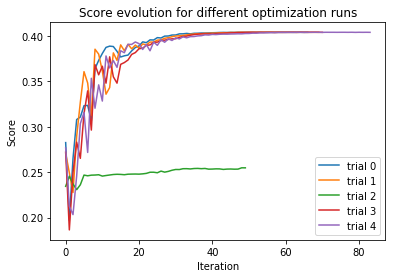

In [71]:
converged_scores = np.array([s[-1] for s in scores_all_trials])
q3 = np.percentile(converged_scores, 75)
q1 = np.percentile(converged_scores, 25)
iqr = q3 - q1
inlier_min = q1 - 1.5 * iqr
inlier_max = q3 + 1.5 * iqr
inliers = np.where((converged_scores > inlier_min) & (converged_scores < inlier_max))[0]
print 'inliers', inliers

plt.figure();
for trial_idx, scores in enumerate(scores_all_trials):
    plt.plot(scores, label='trial ' + str(trial_idx));
plt.xlabel('Iteration');
plt.ylabel('Score');
plt.legend();
plt.title('Score evolution for different optimization runs');

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
T_all_trials = np.array(T_all_trials)
t_std = np.std(pca.fit_transform(T_all_trials[inliers[:,None] ,[3,7,11]])[0])
t_std_um = t_std * XY_PIXEL_DISTANCE_TB
print 'Widest standard deviation of converged translation parameters for different trials: %.2f voxels, %.2f um' % (t_std, t_std_um)

# tx_std = np.std(T_all_trials[inliers, 3])
# ty_std = np.std(T_all_trials[inliers, 7])
# tz_std = np.std(T_all_trials[inliers, 11])
# tx_std_um = tx_std * XY_PIXEL_DISTANCE_TB
# ty_std_um = ty_std * XY_PIXEL_DISTANCE_TB
# tz_std_um = tz_std * XY_PIXEL_DISTANCE_TB
# print 'tx std:', tx_std, 'voxels', tx_std_um, 'um'
# print 'ty std:', ty_std, 'voxels', ty_std_um, 'um'
# print 'tz std:', tz_std, 'voxels', tz_std_um, 'um'

# plt.scatter(np.ones((5,)), np.array(T_all_trials)[:, 3], marker='+');
# plt.scatter(2*np.ones((5,)), np.array(T_all_trials)[:, 7], marker='+');
# plt.scatter(3*np.ones((5,)), np.array(T_all_trials)[:, 11], marker='+');

[[  9.95023610e-01   4.51306890e-02   8.88326286e-02   4.45313952e+01]
 [ -3.38575527e-02   9.91635466e-01  -1.24550266e-01   3.91925465e+01]
 [ -9.37106243e-02   1.20922800e-01   9.88228716e-01  -1.20514424e+01]]
0.403953628149 0.403874524403


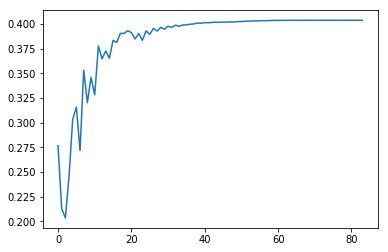

In [72]:
print T.reshape((3,4))
plt.plot(scores);
print max(scores), scores[-1]

# Export parameters and score plots

In [70]:
for trial_idx in range(5):
    
    T = T_all_trials[trial_idx]
    scores = scores_all_trials[trial_idx]
    
    params_fp = \
    DataManager.get_alignment_parameters_filepath(stack_m=stack_moving, stack_f=stack_fixed,
                                                  classifier_setting_m=classifier_setting,
                                                  classifier_setting_f=classifier_setting,
                                                  warp_setting=warp_setting,
                                                  trial_idx=trial_idx)

    DataManager.save_alignment_parameters(params_fp, T, 
                                          aligner.centroid_m, aligner.centroid_f,
                                          aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
                                          aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

    upload_from_ec2_to_s3(params_fp)

    score_plot_fp = \
    DataManager.get_alignment_score_plot_filepath(stack_m=stack_moving, stack_f=stack_fixed,
                                                         classifier_setting_m=classifier_setting,
                                                         classifier_setting_f=classifier_setting,
                                                         warp_setting=warp_setting,
                                                         trial_idx=trial_idx)
    fig = plt.figure();
    plt.plot(scores);
    plt.savefig(score_plot_fp, bbox_inches='tight')
    plt.close(fig)

    upload_from_ec2_to_s3(score_plot_fp)

aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_0/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_0_parameters.txt s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_0/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_0_parameters.txt


Child returned 0
0.45 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_0/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_0_scoreEvolution.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_0/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_0_scoreEvolution.png


Child returned 0
0.45 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_1/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_1_parameters.txt s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_1/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_1_parameters.txt


Child returned 0
0.40 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_1/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_1_scoreEvolution.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_1/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_1_scoreEvolution.png


Child returned 0
0.40 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_2/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_2_parameters.txt s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_2/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_2_parameters.txt


Child returned 0
0.40 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_2/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_2_scoreEvolution.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_2/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_2_scoreEvolution.png


Child returned 0
0.40 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_3/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_3_parameters.txt s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_3/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_3_parameters.txt


Child returned 0
0.40 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_3/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_3_scoreEvolution.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_3/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_3_scoreEvolution.png


Child returned 0
0.40 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_4/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_4_parameters.txt s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_4/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_4_parameters.txt


Child returned 0
0.40 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_4/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_4_scoreEvolution.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_4/atlasV3_down32_scoreVolume_clf_30_warp_10_MD591_down32_scoreVolume_clf_30_trial_4_scoreEvolution.png


Child returned 0
0.41 seconds.


# Draw Results

In [34]:
# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (T, 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

In [36]:
# # Transform moving volume, sided, without surround

# structure = '5N_L'

# vol_m = DataManager.load_volume(stack=stack_moving, structure=structure, downscale=32)

# volume_m_alignedTo_f = \
# transform_volume(vol=vol_m, global_params=global_params, centroid_m=centroid_m, centroid_f=centroid_f,
#                   xdim_f=xdim_f, ydim_f=ydim_f, zdim_f=zdim_f)

In [37]:
# # Set colors for different contour level
# levels = [0.1, 0.25, 0.5, 0.75, .99]
# level_colors = {level: (int(level*255),0,0) for level in levels}

In [42]:
# # Generate overlay visualization

# # For getting correct contour location

# # xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f, zmin_vol_f, zmax_vol_f = \
# # DataManager.load_volume_bbox(stack=stack_fixed, type='score', structure='7N', 
# #                              downscale=32, classifier_setting=classifier_setting)
# # print xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f, zmin_vol_f, zmax_vol_f

# xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f = DataManager.load_cropbox(stack=stack_fixed)[:4]

# # Generate atlas overlay image for every section

# zf, zl = bbox_3d(volume_m_alignedTo_f)[4:]
# sec_first = DataManager.convert_z_to_section(stack=stack_fixed, z=zf, downsample=32)
# sec_last = DataManager.convert_z_to_section(stack=stack_fixed, z=zl, downsample=32)

# for sec in range(sec_first, sec_last+1):
# # for sec in [155]:
    
#     if is_invalid(metadata_cache['sections_to_filenames'][stack_fixed][sec]):
#         continue
    
#     try:
#         img_fn = DataManager.get_image_filepath(stack=stack_fixed, section=sec, resol='thumbnail', version='cropped_tif')
#         img = imread(img_fn)
# #         img = imread(DataManager.get_scoremap_viz_filepath(stack=stack_fixed, section=sec, 
# #                                                            downscale=32,
# #                                                            structure=convert_to_original_name(structure), 
# #                                                            setting=classifier_setting))
#     except:
#         sys.stderr.write('Error loading scoremap for section %d\n' % sec)
#         continue
    
#     viz = img.copy()
    
#     z1, z2 = DataManager.convert_section_to_z(stack=stack_fixed, sec=sec, downsample=32)
#     z = int(z1)
    
#     # Find moving volume annotation contours
#     c = 0
#     vol = volume_m_alignedTo_f
#     for level in levels:
#         cnts = find_contours(vol[..., z], level=level) # rows, cols
#         c += len(cnts)
#         for cnt in cnts:
#             # r,c to x,y
#             cnt_on_cropped = cnt[:, ::-1] + (xmin_vol_f, ymin_vol_f)
#             cv2.polylines(viz, [cnt_on_cropped.astype(np.int)], True, level_colors[level], 1)
    
#     if c > 0:    
# #         plt.figure(figsize=(20,20));
#         plt.figure();
#         plt.title("sec=%d, z=%d, c=%d" % (sec, z, c));
#         plt.imshow(viz);
#         plt.show();


Error loading scoremap for section 143
Error loading scoremap for section 144
Error loading scoremap for section 145
Error loading scoremap for section 146
Error loading scoremap for section 147
Error loading scoremap for section 148
Error loading scoremap for section 149
Error loading scoremap for section 150
Error loading scoremap for section 151
Error loading scoremap for section 152
Error loading scoremap for section 153
Error loading scoremap for section 154
Error loading scoremap for section 155
Error loading scoremap for section 156
Error loading scoremap for section 157
Error loading scoremap for section 158
Error loading scoremap for section 159
Error loading scoremap for section 160
Error loading scoremap for section 161
Error loading scoremap for section 162
Error loading scoremap for section 163
Error loading scoremap for section 164
Error loading scoremap for section 165
Error loading scoremap for section 166
Error loading scoremap for section 167
Error loading scoremap fo